# Testing Jacobians with `TwoSectorModel_HANK`
CREATES THE SAME JACOBIANS AS INDSHOCKCONSUMER.
NOTE THAT THIS VERSION HAS
1. PermGroFac of not 1
2. Takes the infinite horizon solution at the last period only for cFUnc and vPFunc and not MPCmin, MPCmax, hNrm

In [1]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.distribution import DiscreteDistributionLabeled
import matplotlib.pyplot as plt
from ConsIndShockModel_HANK import HANKIncShkDstn
# from HARK.utilities import jump_to_grid_1D, jump_to_grid_2D
import numba
from ConsIndShockModel_HANK import IndShockConsumerType 

from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import numpy as np
from copy import copy, deepcopy

from utilities_TwoSectorModel import jump_to_grid_1D, gen_tran_matrix_1D_Markov

In [2]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.0
p_i_to_f = 0.0
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

In [3]:

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
T_cycles = 1
cycles = 0
LivPrb = .99375
Z_ss = 0.7925
init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([0.05, 0.05])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Z_ss, Z_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [0.0, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.01 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.5, 0.5],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector['TranShkMean_Func'] = [function]

In [4]:
# Make a consumer with serially correlated unemployment, subject to boom and bust cycles
init_twosector["global_markov"] = False
TwoSectorExample = TwoSectorMarkovConsumerType(**init_twosector)


In [5]:
### RFREE WITH TIME VARYING
TwoSectorExample.assign_parameters(
    Rfree=[np.array(2 * [1 + r_ss])] * T_cycles
)

In [6]:
TwoSectorExample.solve()

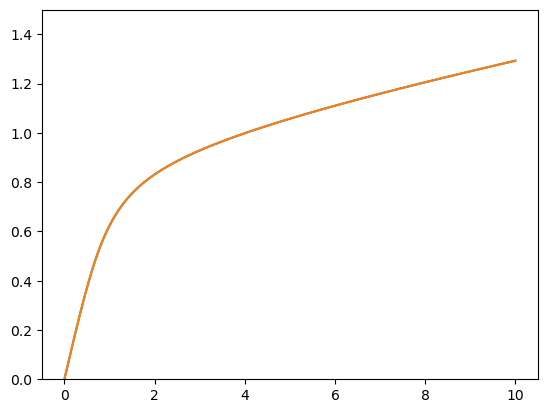

In [7]:
### Plot policy functions
mGrid = np.linspace(0, 10, 1000)
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid))
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid))
plt.ylim(0, 1.5)
plt.show()

In [8]:
TwoSectorExample.compute_steady_state()

(1.2222238166427952, 0.8163455887194062)

In [9]:
CJACR, AJACR = TwoSectorExample.calc_jacobian("Rfree", 300)

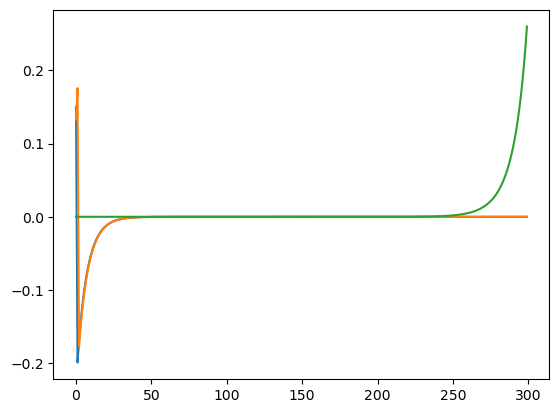

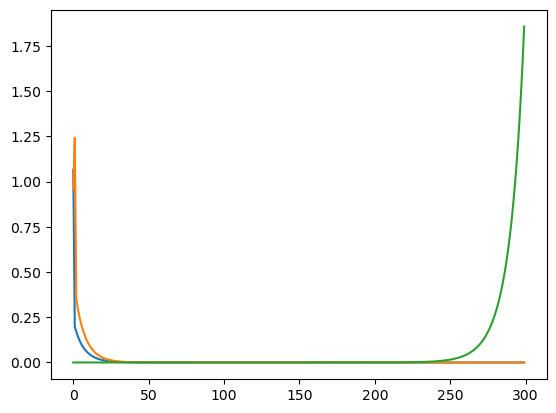

In [10]:
plt.plot(CJACR[0])
plt.plot(CJACR[1])
plt.plot(CJACR[-1])
plt.show()

plt.plot(AJACR[0])
plt.plot(AJACR[1])
plt.plot(AJACR[-1])

plt.show()

## STEP BY STEP

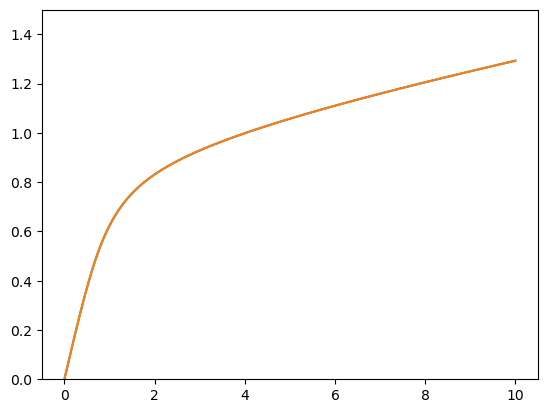

In [11]:
### Plot policy functions
mGrid = np.linspace(0, 10, 1000)
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid))
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid))
plt.ylim(0, 1.5)
plt.show()

In [12]:
T = 300
shk_param = "Rfree"

In [13]:
# Set up finite Horizon dictionary
params = deepcopy(TwoSectorExample.__dict__["parameters"])
params["T_cycle"] = T  # Dimension of Jacobian Matrix
params["cycles"] = 1  # required

# Specify a dictionary of lists because problem we are solving is technically finite horizon so variables can be time varying (see section on fake news algorithm in https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434 )
params["LivPrb"] = params["T_cycle"] * [TwoSectorExample.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [TwoSectorExample.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [TwoSectorExample.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [TwoSectorExample.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [TwoSectorExample.Rfree[0]]
params["UnempPrb"] = params["T_cycle"] * [TwoSectorExample.UnempPrb[0]]
params["IncUnemp"] = params["T_cycle"] * [TwoSectorExample.IncUnemp[0]]

params['wage'] = params['T_cycle']*[TwoSectorExample.wage[0]]
params['taxrate'] = params['T_cycle']*[TwoSectorExample.taxrate[0]]
params['labor'] = params['T_cycle']*[TwoSectorExample.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[TwoSectorExample.TranShkMean_Func[0]]

params["MrkvArray"] = params["T_cycle"] * [TwoSectorExample.MrkvArray[0]]


In [14]:
# Create instance of a finite horizon agent
FinHorizonAgent = TwoSectorMarkovConsumerType(**params)
# FinHorizonAgent.cycles = 1  # required done above


In [15]:
# delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.del_from_time_inv("Rfree")
# Add Rfree to time varying list to be able to introduce time varying interest rates
FinHorizonAgent.add_to_time_vary("Rfree")

# Set Terminal Solution as Steady State Consumption Function
# FinHorizonAgent.cFunc_terminal_ = deepcopy(TwoSectorExample.solution[0].cFunc)
#FinHorizonAgent.solution_terminal = deepcopy(TwoSectorExample.solution[0])
# FinHorizonAgent.cFunc_terminal_ = deepcopy(TwoSectorExample.solution[0].cFunc)

FinHorizonAgent.update_solution_terminal()
# FinHorizonAgent.solution_terminal = deepcopy(TwoSectorExample.solution_terminal)
FinHorizonAgent.solution_terminal.cFunc = deepcopy(TwoSectorExample.solution[0].cFunc)
FinHorizonAgent.solution_terminal.vPfunc = deepcopy(TwoSectorExample.solution[0].vPfunc)




In [16]:
dx = 0.0001  # Size of perturbation
# Period in which the change in the interest rate occurs (second to last period)
i = params["T_cycle"] - 1

FinHorizonAgent.IncShkDstn = params["T_cycle"] * [TwoSectorExample.IncShkDstn[0]]

# If parameter is in time invariant list then add it to time vary list
FinHorizonAgent.del_from_time_inv(shk_param)
FinHorizonAgent.add_to_time_vary(shk_param)

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(TwoSectorExample, shk_param)) == list:
    peturbed_list = (
        (i) * [getattr(TwoSectorExample, shk_param)[0]]
        + [getattr(TwoSectorExample, shk_param)[0] + dx]
        + (params["T_cycle"] - i - 1) * [getattr(TwoSectorExample, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
        (i) * [getattr(TwoSectorExample, shk_param)]
        + [getattr(TwoSectorExample, shk_param) + dx]
        + (params["T_cycle"] - i - 1) * [getattr(TwoSectorExample, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(FinHorizonAgent, shk_param, peturbed_list)

In [17]:
# Update income process if perturbed parameter enters the income shock distribution
FinHorizonAgent.update_income_process_Markov()
# update everyhing --> MAKES THINGS WORSE (UPDATES FINAL PERIOD)
# FinHorizonAgent.update()

In [18]:
# Solve
# FinHorizonAgent.solution[300] = deepcopy(TwoSectorExample.solution[0].cFunc)
FinHorizonAgent.solve()

### Show Consumption Functions

In [19]:
FinHorizonAgent.define_distribution_grid()

dist_mGrid = FinHorizonAgent.dist_mGrid

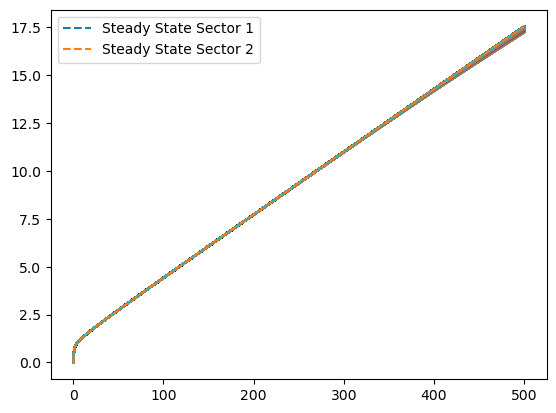

In [20]:
### Plot policy functions
for t in range(T):
    plt.plot(dist_mGrid, FinHorizonAgent.solution[t].cFunc[0](dist_mGrid))
    plt.plot(dist_mGrid, FinHorizonAgent.solution[t].cFunc[1](dist_mGrid))
plt.plot(dist_mGrid, TwoSectorExample.solution[0].cFunc[0](dist_mGrid), '--', label = "Steady State Sector 1")
plt.plot(dist_mGrid, TwoSectorExample.solution[0].cFunc[1](dist_mGrid), '--', label = "Steady State Sector 2")
plt.legend()
plt.show()

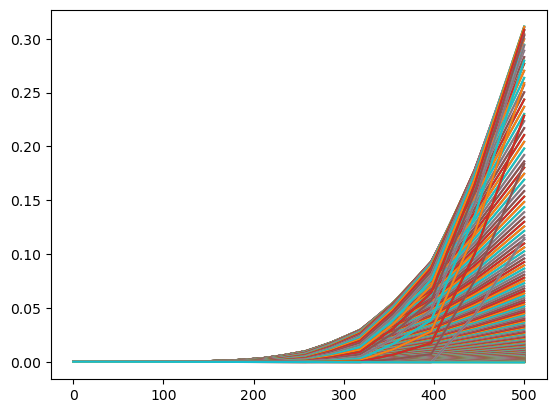

In [21]:
for t in range(T):
    plt.plot(dist_mGrid, TwoSectorExample.solution[0].cFunc[0](dist_mGrid) - FinHorizonAgent.solution[t].cFunc[0](dist_mGrid), label = "Steady State Sector 1")
    plt.plot(dist_mGrid, TwoSectorExample.solution[0].cFunc[1](dist_mGrid) - FinHorizonAgent.solution[t].cFunc[1](dist_mGrid), label = "Steady State Sector 2")
# plt.legend()
plt.show()

In [22]:
#FinHorizonAgent.Rfree = params["T_cycle"] * [self.Rfree]
# Use Harmenberg Neutral Measure
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.update_income_process_Markov()

# Calculate Transition Matrices
FinHorizonAgent.define_distribution_grid()
FinHorizonAgent.calc_transition_matrix_Markov()



In [23]:
##########
# STEP 1 # of fake news algorithm, As in the paper for Curly Y and Curly D. Here the policies are over assets and consumption so we denote them as curly C and curly D.
##########
# Policy Functions are now arrays with dimension (Nr of States x len(dist_mGrid)). We need to stack them to get a vector.
a_ss = TwoSectorExample.aPol_Grid.flatten()  # steady state Asset Policy
c_ss = TwoSectorExample.cPol_Grid.flatten()  # steady state Consumption Policy
tranmat_ss = TwoSectorExample.tran_matrix  # Steady State Transition Matrix

# List of asset policies grids where households expect the shock to occur in the second to last Period
## Need to concatenate for each T
a_t = []
for t in range(T):
    a_t.append(FinHorizonAgent.aPol_Grid[t].flatten())
# add steady state assets to list as it does not get appended in calc_transition_matrix method
a_t.append(TwoSectorExample.a_ss)

# List of consumption policies grids where households expect the shock to occur in the second to last Period
# c_t = [np.concatenate(FinHorizonAgent.cPol_Grid)]
c_t = []
for t in range(T):
    c_t.append(FinHorizonAgent.cPol_Grid[t].flatten())
# add steady state consumption to list as it does not get appended in calc_transition_matrix method
c_t.append(TwoSectorExample.c_ss)

da0_s = []  # Deviation of asset policy from steady state policy
dc0_s = []  # Deviation of Consumption policy from steady state policy
for i in range(T):
    da0_s.append(a_t[T - i] - a_ss)
    dc0_s.append(c_t[T - i] - c_ss)

da0_s = np.array(da0_s)
dc0_s = np.array(dc0_s)


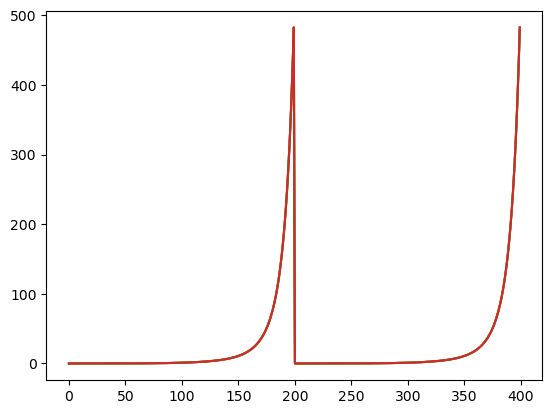

In [24]:
plt.plot(a_t[0])
plt.plot(a_t[1])
plt.plot(a_t[10])
plt.plot(a_t[50])

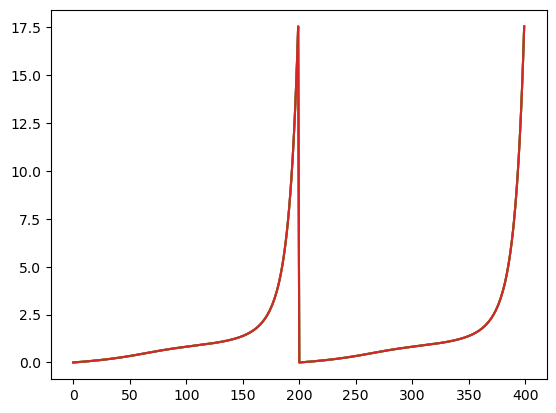

In [25]:
plt.plot(c_t[0])
plt.plot(c_t[1])
plt.plot(c_t[10])
plt.plot(c_t[50])

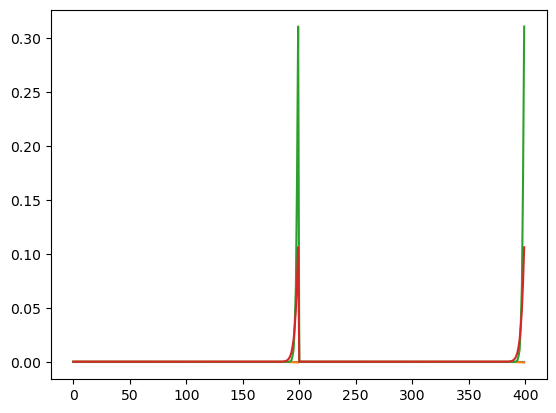

In [26]:
plt.plot(da0_s[0])
plt.plot(da0_s[1])
plt.plot(da0_s[10])
plt.plot(da0_s[50])

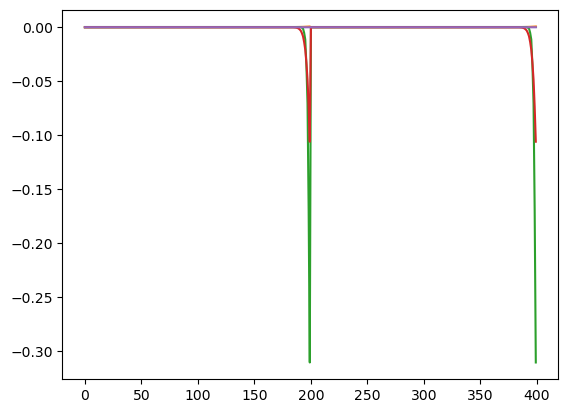

In [27]:
plt.plot(dc0_s[0])
plt.plot(dc0_s[1])
plt.plot(dc0_s[10])
plt.plot(dc0_s[50])
plt.plot(dc0_s[-1])

In [28]:
# Steady state distribution of market resources (permanent income weighted distribution)
D_ss = TwoSectorExample.vec_erg_dstn.T[0]
dA0_s = []
dC0_s = []
for i in range(T):
    dA0_s.append(np.dot(da0_s[i], D_ss))
    dC0_s.append(np.dot(dc0_s[i], D_ss))

dA0_s = np.array(dA0_s)


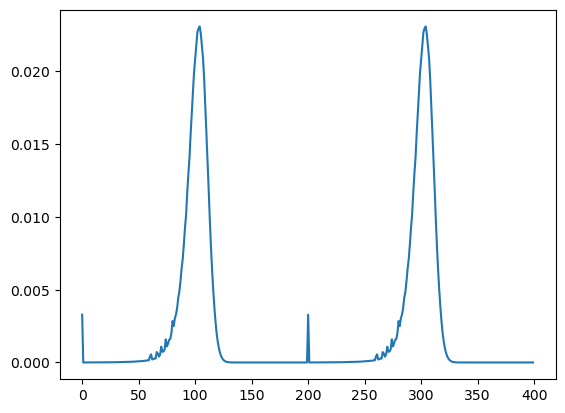

In [29]:
plt.plot(D_ss)

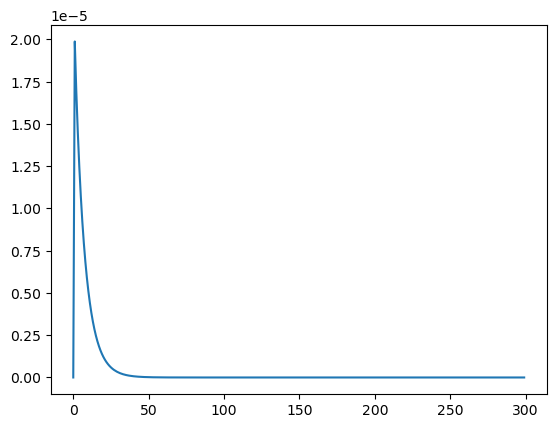

In [30]:
plt.plot(dA0_s)

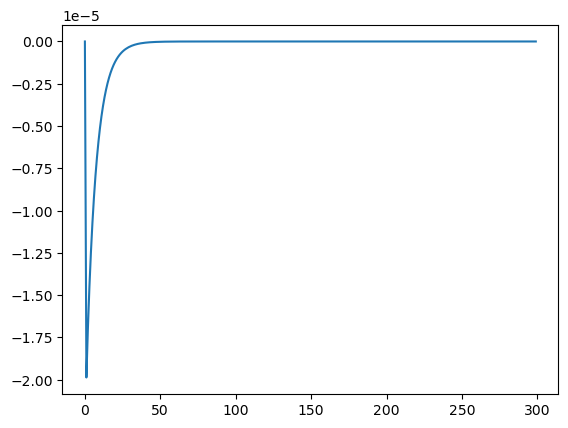

In [31]:
plt.plot(dC0_s)

In [32]:
# This is equivalent to the curly Y scalar detailed in the first step of the algorithm
A_curl_s = dA0_s / dx

dC0_s = np.array(dC0_s)
C_curl_s = dC0_s / dx

# List of computed transition matrices for each period
tranmat_t = FinHorizonAgent.tran_matrix
tranmat_t.append(tranmat_ss)

# List of change in transition matrix relative to the steady state transition matrix
dlambda0_s = []
for i in range(T):
    dlambda0_s.append(tranmat_t[T  -   i] - tranmat_ss)

dlambda0_s = np.array(dlambda0_s)



In [33]:
# This is equivalent to the curly Y scalar detailed in the first step of the algorithm
A_curl_s = dA0_s / dx

dC0_s = np.array(dC0_s)
C_curl_s = dC0_s / dx

# List of computed transition matrices for each period
tranmat_t = FinHorizonAgent.tran_matrix
tranmat_t.append(tranmat_ss)

# List of change in transition matrix relative to the steady state transition matrix
dlambda0_s = []
for i in range(T):
    dlambda0_s.append(tranmat_t[T  -   i] - tranmat_ss)

dlambda0_s = np.array(dlambda0_s)



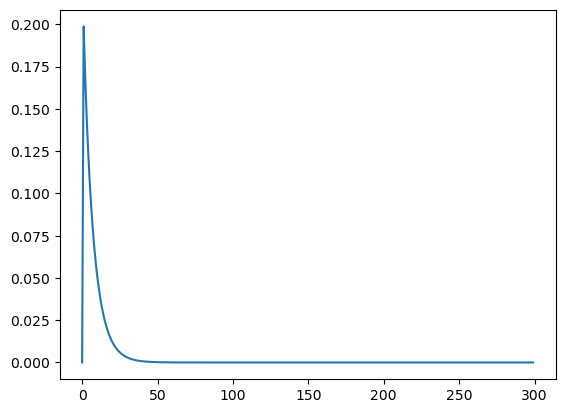

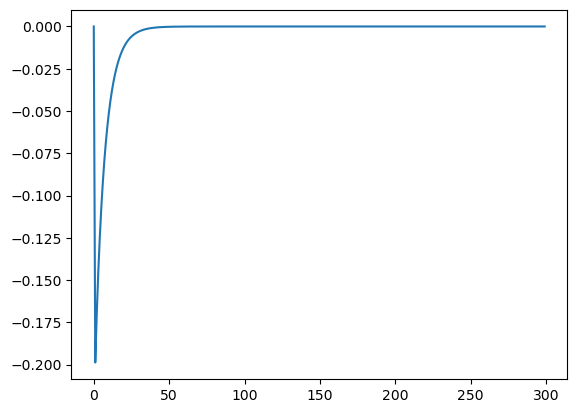

In [34]:
plt.plot(A_curl_s)
plt.show()
plt.plot(C_curl_s)
plt.show()

In [35]:
dD0_s = []
for i in range(T):
    dD0_s.append(np.dot(dlambda0_s[i], D_ss))

dD0_s = np.array(dD0_s)
D_curl_s = dD0_s / dx  # Curly D in the sequence space jacobian

In [36]:
dlambda0_s[1]

array([[ 0.00000000e+00, -6.55160108e-07, -1.32814875e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.55160108e-07,  1.32814875e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.23368626e-04, -5.24863620e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.12083855e-04,  2.19733049e-04, -5.14433117e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  3.05130570e-04,  5.14433117e-04]])

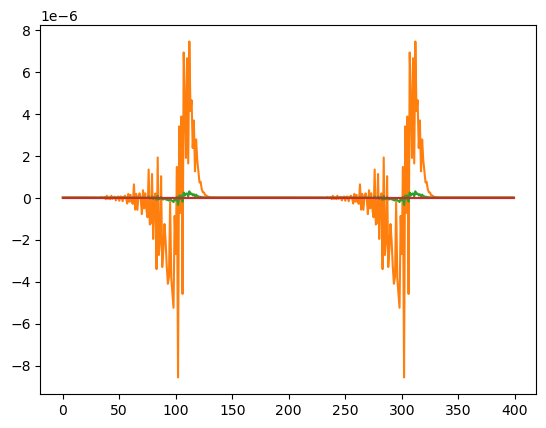

In [37]:
plt.plot(dD0_s[0])
plt.plot(dD0_s[1])
plt.plot(dD0_s[10])
plt.plot(dD0_s[-1])

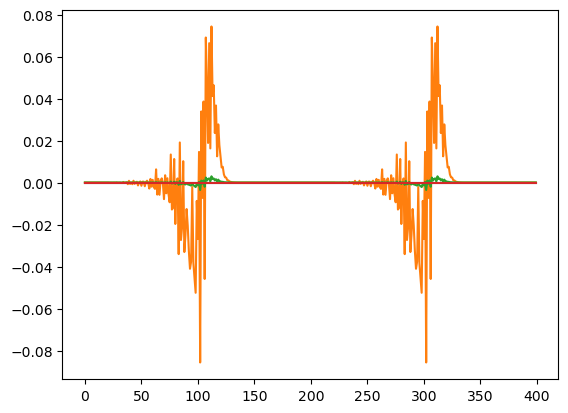

In [38]:
plt.plot(D_curl_s[0])
plt.plot(D_curl_s[1])
plt.plot(D_curl_s[10])
plt.plot(D_curl_s[-1])

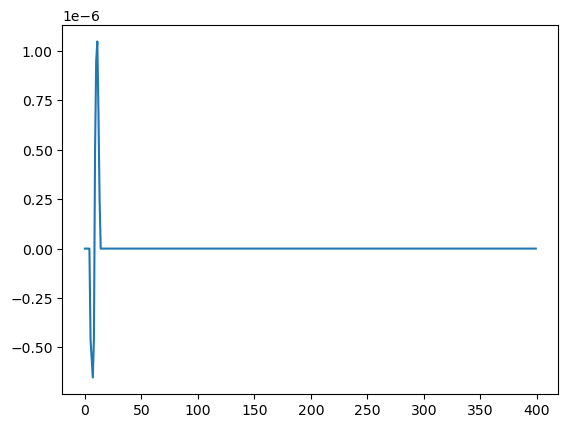

In [39]:
plt.plot(dlambda0_s[2][2])

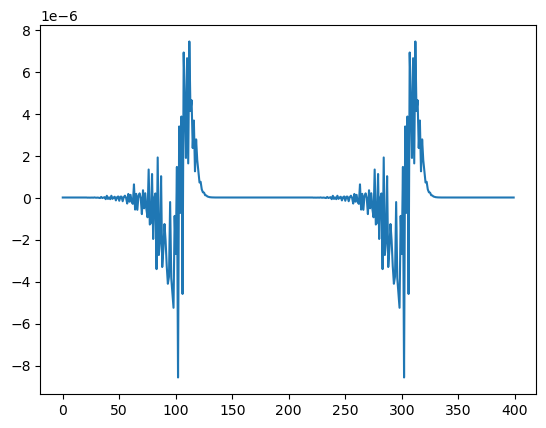

In [40]:
plt.plot(dD0_s[1])

In [41]:
########
# STEP2 # of fake news algorithm
########

# Expectation Vectors
exp_vecs_a = []
exp_vecs_c = []

# First expectation vector is the steady state policy
exp_vec_a = a_ss
exp_vec_c = c_ss
for i in range(T):
    exp_vecs_a.append(exp_vec_a)
    exp_vec_a = np.dot(tranmat_ss.T, exp_vec_a)

    exp_vecs_c.append(exp_vec_c)
    exp_vec_c = np.dot(tranmat_ss.T, exp_vec_c)

# for i in range(T):
#     exp_vecs_a.append(exp_vec_a)
#     exp_vec_a = np.dot(tranmat_ss, exp_vec_a)

#     exp_vecs_c.append(exp_vec_c)
#     exp_vec_c = np.dot(tranmat_ss.T, exp_vec_c)

# for i in range(T):
#     exp_vecs_a.append(exp_vec_a)
#     exp_vec_a = np.dot(exp_vec_a, tranmat_ss )

#     exp_vecs_c.append(exp_vec_c)
#     exp_vec_c = np.dot(exp_vec_c, tranmat_ss)

# Turn expectation vectors into arrays
exp_vecs_a = np.array(exp_vecs_a)
exp_vecs_c = np.array(exp_vecs_c)


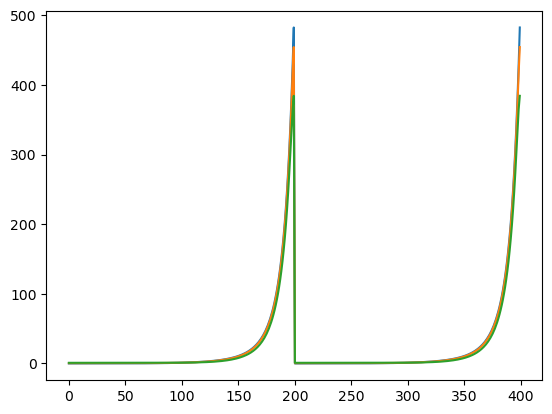

In [42]:
plt.plot(exp_vecs_a[0])
plt.plot(exp_vecs_a[2])
plt.plot(exp_vecs_a[10])

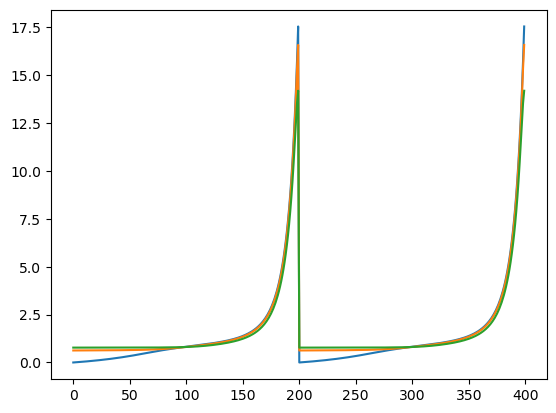

In [43]:
plt.plot(exp_vecs_c[0])
plt.plot(exp_vecs_c[2])
plt.plot(exp_vecs_c[10])

In [44]:
#########
# STEP3 # of the algorithm. In particular equation 26 of the published paper.
#########
# Fake news matrices
Curl_F_A = np.zeros((T, T))  # Fake news matrix for assets
Curl_F_C = np.zeros((T, T))  # Fake news matrix for consumption

# First row of Fake News Matrix
Curl_F_A[0] = A_curl_s
Curl_F_C[0] = C_curl_s


for i in range(T - 1):
    for j in range(T):
        Curl_F_A[i + 1][j] = np.dot(exp_vecs_a[i], D_curl_s[j])
        Curl_F_C[i + 1][j] = np.dot(exp_vecs_c[i], D_curl_s[j])


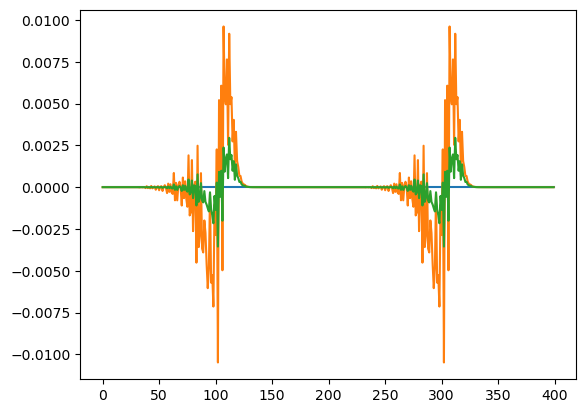

In [45]:
plt.plot(D_curl_s[0])
plt.plot(D_curl_s[2])
plt.plot(D_curl_s[10])

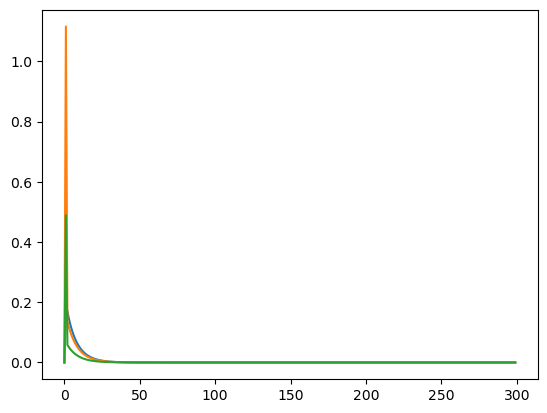

In [46]:
plt.plot(Curl_F_A[0])
plt.plot(Curl_F_A[2])
plt.plot(Curl_F_A[10])

In [47]:
########
# STEP4 #  of the algorithm
########

# Function to compute jacobian matrix from fake news matrix
def J_from_F(F):
    J = F.copy()
    for t in range(1, F.shape[0]):
        J[1:, t] += J[:-1, t-1]
    return J

J_A = J_from_F(Curl_F_A)
J_C = J_from_F(Curl_F_C)


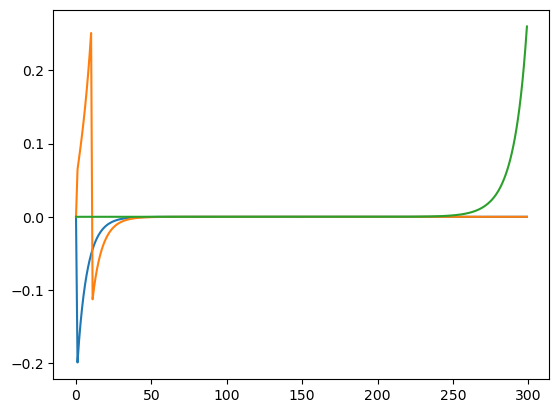

In [48]:
plt.plot(J_C[0])
plt.plot(J_C[10])
plt.plot(J_C[-1])